<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/342_poisson_model.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(poisson_model_notebook)=
# Modello di Poisson

In questo capitolo, esamineremo la stima del parametro "rate" di un modello di Poisson utilizzando PyMC. Il modello di Poisson è uno strumento impiegato per modellare il conteggio di eventi rari in un intervallo di tempo o spazio. Il parametro "rate" in questo contesto rappresenta il tasso di incidenza medio degli eventi nel sistema considerato, ovvero il numero medio di eventi che si verificano nell'unità di tempo o spazio.

Attraverso l'utilizzo di PyMC, otterremo la distribuzione a posteriori del parametro "rate" che tiene conto dell'incertezza nella stima. Ciò ci permetterà di ottenere stime puntuali e intervalli di credibilità per il parametro "rate", fornendo una migliore comprensione dell'andamento degli eventi nel sistema considerato e una misura dell'incertezza associata alla nostra stima.

Il vantaggio principale di utilizzare la stima MCMC con PyMC è la sua capacità di gestire casi in cui i dati possono essere scarsi o non soddisfare gli assunti delle tecniche di stima tradizionali. Inoltre, attraverso questo approccio, potremo esplorare il comportamento del modello di Poisson e valutarne la capacità di descrivere correttamente il fenomeno oggetto di studio, consentendoci di ottenere una migliore comprensione e interpretazione dei dati osservati.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

Come spiegato [qui](https://github.com/washingtonpost/data-police-shootings), i dati che esamineremo sono raccolti dal Washington Post con lo scopo di registrare ogni sparatoria mortale negli Stati Uniti ad opera di agenti di polizia, a partire dal 1° gennaio 2015. Il Washington Post ha adottato un approccio sistematico e accurato nella raccolta di queste informazioni, fornendo dati che possono essere utili per valutare i problemi legati alla violenza delle forze di polizia negli Stati Uniti.

## Domanda della ricerca

Lo scopo della presente analisi dei dati è determinare il tasso di sparatorie fatali da parte della polizia negli Stati Uniti per ogni anno, e fornire una stima dell'incertezza associata a questo valore.

## Importazione e pre-processing dei dati

In [3]:
url = "https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/v2/fatal-police-shootings-data.csv"
fps_dat = pd.read_csv(url)

fps_dat.head()

,id,date,threat_type,flee_status,armed_with,city,county,state,latitude,longitude,location_precision,name,age,gender,race,race_source,was_mental_illness_related,body_camera,agency_ids
0,3,2015-01-02,point,not,gun,Shelton,Mason,WA,47.246826,-123.121592,not_available,Tim Elliot,53.0,male,A,not_available,True,False,73
1,4,2015-01-02,point,not,gun,Aloha,Washington,OR,45.487421,-122.891696,not_available,Lewis Lee Lembke,47.0,male,W,not_available,False,False,70
2,5,2015-01-03,move,not,unarmed,Wichita,Sedgwick,KS,37.694766,-97.280554,not_available,John Paul Quintero,23.0,male,H,not_available,False,False,238
3,8,2015-01-04,point,not,replica,San Francisco,San Francisco,CA,37.762910,-122.422001,not_available,Matthew Hoffman,32.0,male,W,not_available,True,False,196
4,9,2015-01-04,point,not,other,Evans,Weld,CO,40.383937,-104.692261,not_available,Michael Rodriguez,39.0,male,H,not_available,False,False,473


In [4]:
# Convert date
fps_dat["date"] = pd.to_datetime(fps_dat["date"])

# Create a new column 'year' to store the year information from the 'date' column
fps_dat["year"] = fps_dat["date"].dt.year

fps_dat.columns

Index(['id', 'date', 'threat_type', 'flee_status', 'armed_with', 'city',
       'county', 'state', 'latitude', 'longitude', 'location_precision',
       'name', 'age', 'gender', 'race', 'race_source',
       'was_mental_illness_related', 'body_camera', 'agency_ids', 'year'],
      dtype='object')

In [5]:
# Filter out rows with year equal to 2023
fps = fps_dat[fps_dat["year"] != 2023]

# Count occurrences of each year in fps
year_counts = fps["year"].value_counts()
print(year_counts)

year
2022    1096
2021    1048
2020    1019
2019     997
2015     995
2018     992
2017     983
2016     958
Name: count, dtype: int64


In [8]:
# Define the data
data = {
    "year": [2022, 2021, 2020, 2019, 2015, 2018, 2017, 2016],
    "events": [1096, 1048, 1019, 997, 995, 992, 983, 958],
}
# Convert the data to a DataFrame
df = pd.DataFrame(data)
print(df)

   year  events
0  2022    1096
1  2021    1048
2  2020    1019
3  2019     997
4  2015     995
5  2018     992
6  2017     983
7  2016     958


## Modello di Poisson

Il nostro interesse riguarda il tasso di occorrenza di sparatorie fatali da parte della polizia per anno. Indicheremo questo tasso come $\theta$, e il suo intervallo di valori possibili è $[0, \infty)$. Un modello di Poisson rappresenta tipicamente il punto di partenza per l'analisi di dati relativi alle frequenze assolute di un evento in un intervallo di tempo fissato. Il modello presuppone che i dati seguano una distribuzione di Poisson con un parametro di tasso $\theta$:

$$
P(y \mid \theta) \propto \theta^y * \exp(−\theta),
$$

dove i dati $y$ possono assumere solo valori interi non negativi.

## Distribuzione a priori

Come distribuzione a priori per il parametro $\theta$ nel modello di Poisson possiamo usare la distribuzione Gamma, poiché è una scelta coniugata. Ciò significa che, quando viene combinata con la distribuzione di Poisson come verosimiglianza dei dati, la distribuzione Gamma produce una distribuzione a posteriori con una forma analitica semplice. Questa caratteristica semplifica il processo di inferenza bayesiana.

Nel nostro caso, il parametro $\theta$ rappresenta il tasso di occorrenza di sparatorie fatali per anno negli Stati Uniti. Prima di osservare i dati effettivi riportati dal Washington Post, abbiamo una conoscenza limitata su tale fenomeno. Pertanto, dobbiamo specificare una distribuzione a priori per $\theta$ che rifletta la nostra incertezza iniziale. As esempio, possiamo ipotizzare che ci sia, in media, una sparatoria mortale per stato al mese, quindi 12 sparatorie all'anno per stato. Questo ci porta a una stima iniziale di 600 sparatorie fatali negli Stati Uniti ogni anno. Dato che non siamo molto sicuri di questa ipotesi, vogliamo specificare una distribuzione a priori con un certo grado di incertezza. Imponiamo dunque shape = 3. Questa scelta implica una distribuzione a priori Gamma che rappresenta un'incertezza notevole riguardo al tasso di sparatorie fatali. Se il parametro shape è uguale a 3 e la media della distribuzione gamma è 600, allora il parametro scale è uguale a 600 / 2 = 200. Di seguito viene riportato un grafico della distribuzione gamma scelta.

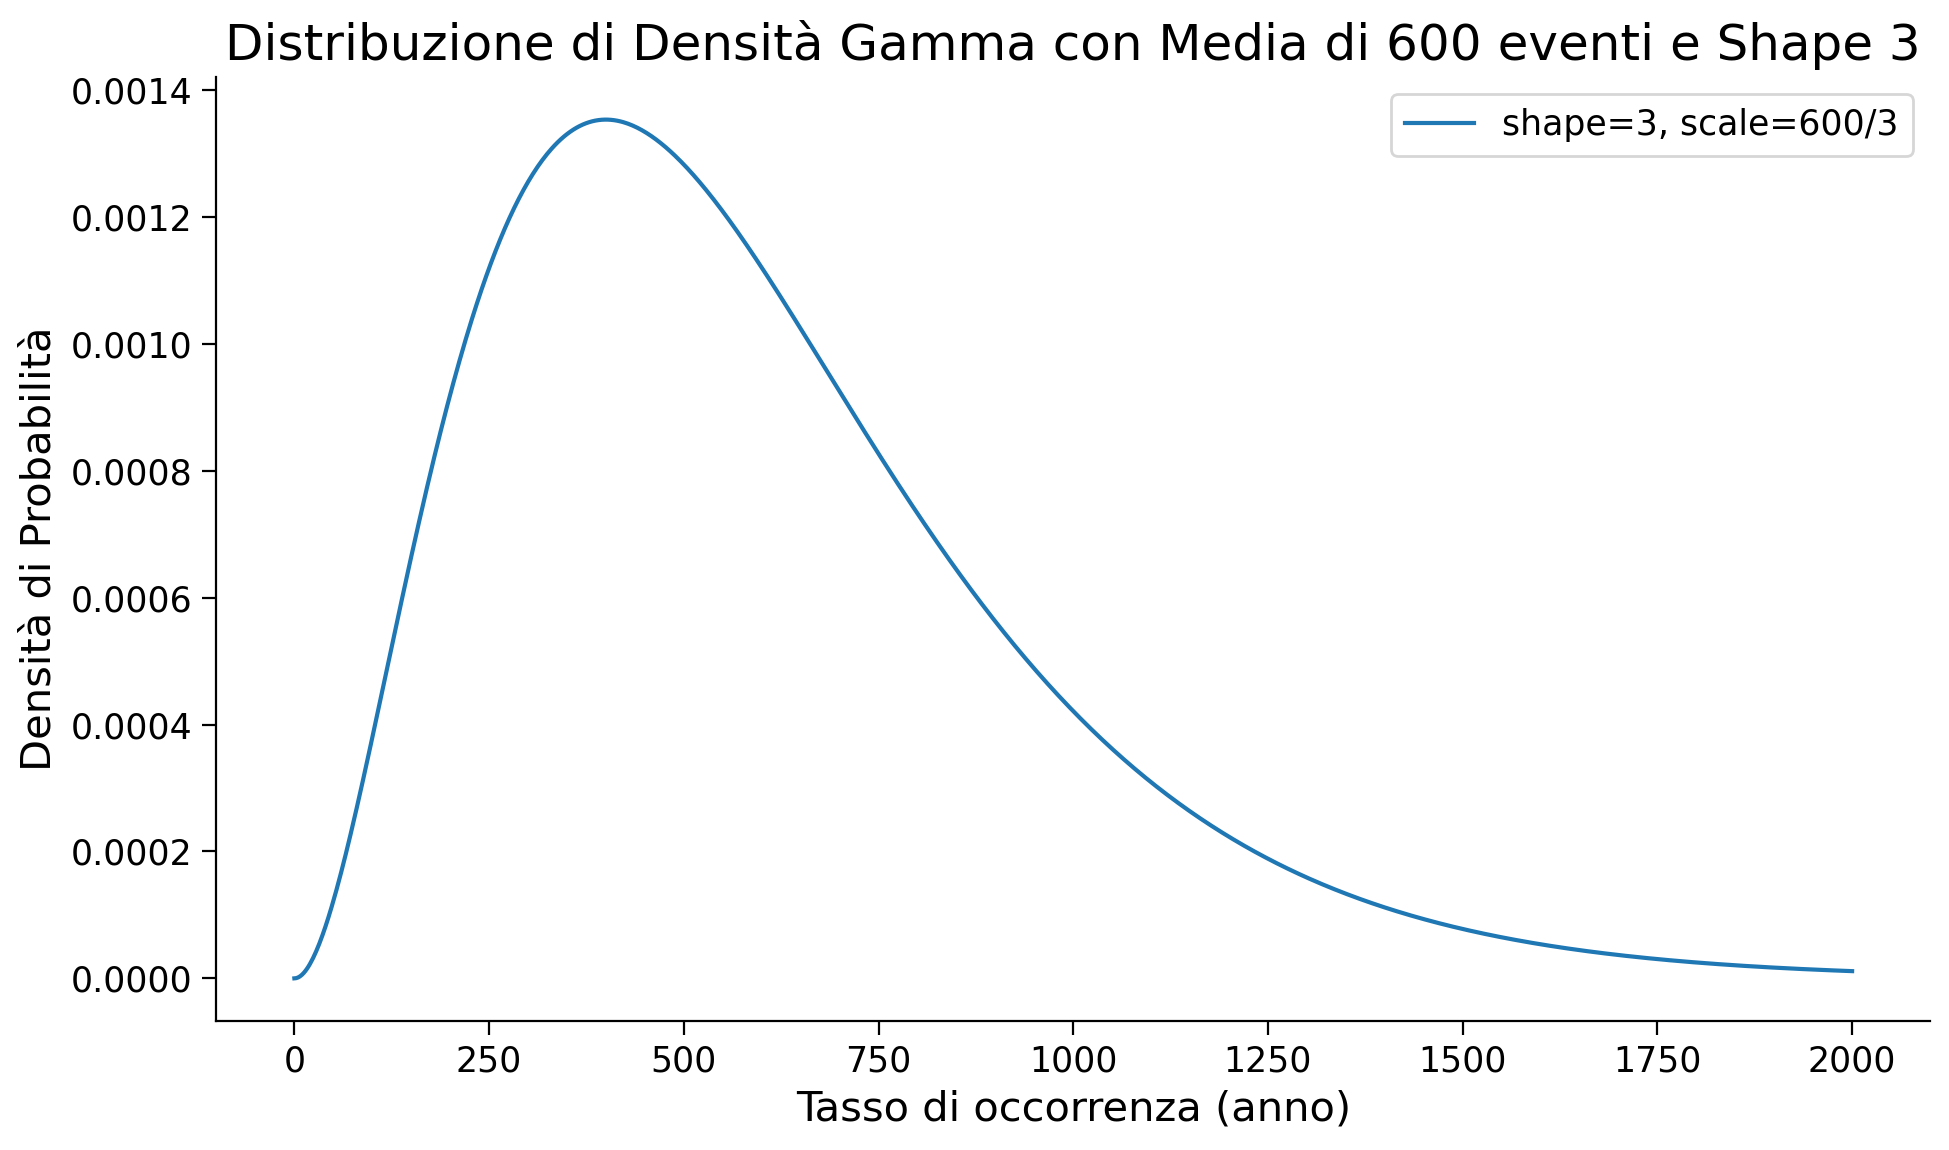

In [9]:
# Parametri della distribuzione gamma
shape = 3
mean = 600  # Media della distribuzione 
# Calcolo del parametro di scala in base alla media e shape
scale = mean / shape

# Array di valori da 0 a 20 per il grafico 
x = np.linspace(0, 2000, 1000)

# Specificazione della distribuzione gamma con i parametri indicati
gamma_dist = stats.gamma(a=shape, scale=scale)

# Calcolo della funzione di densità di probabilità (PDF) della distribuzione gamma
pdf_values = gamma_dist.pdf(x)

# Plot del grafico
plt.figure(figsize=(10, 6))
plt.plot(x, pdf_values, label='shape=3, scale=600/3')
plt.xlabel('Tasso di occorrenza (anno)')
plt.ylabel('Densità di Probabilità')
plt.title('Distribuzione di Densità Gamma con Media di 600 eventi e Shape 3')
plt.legend();

## Modello di Poisson con PyMC

In PyMC, la distribuzione Gamma è parametrizzata con alpha = shape e beta = 1/scale. Nel nostro caso,  shape = 3 e scale = 200. Pertanto, nella parametrizzazione PyMC, la distribuzione Gamma avrà parametri alpha = 3 e beta = 1 / 200. Formuliamo dunque il modello di Poisson usando questi iper-parametri per la distribuzione a priori del parametro $\lambda$ (`rate`) della distribuzione di Poisson.

In [10]:
with pm.Model() as poisson_model:
    alpha = 3  # Shape hyperparameter for the Gamma prior
    beta = 1/200  # Rate hyperparameter for the Gamma prior
    rate = pm.Gamma("rate", alpha=alpha, beta=beta)
    # Likelihood (Poisson) using the observed data
    y = df["events"].values
    events = pm.Poisson("events", mu=rate, observed=y)

Eseguiamo il prior predictive check per verificare che l'instanziazione del modello sia corretta per quel che riguarda la distribuzione a priori.

In [11]:
with poisson_model:
    idata_prior = pm.sample_prior_predictive(samples=1000, random_seed=RANDOM_SEED)

Sampling: [events, rate]


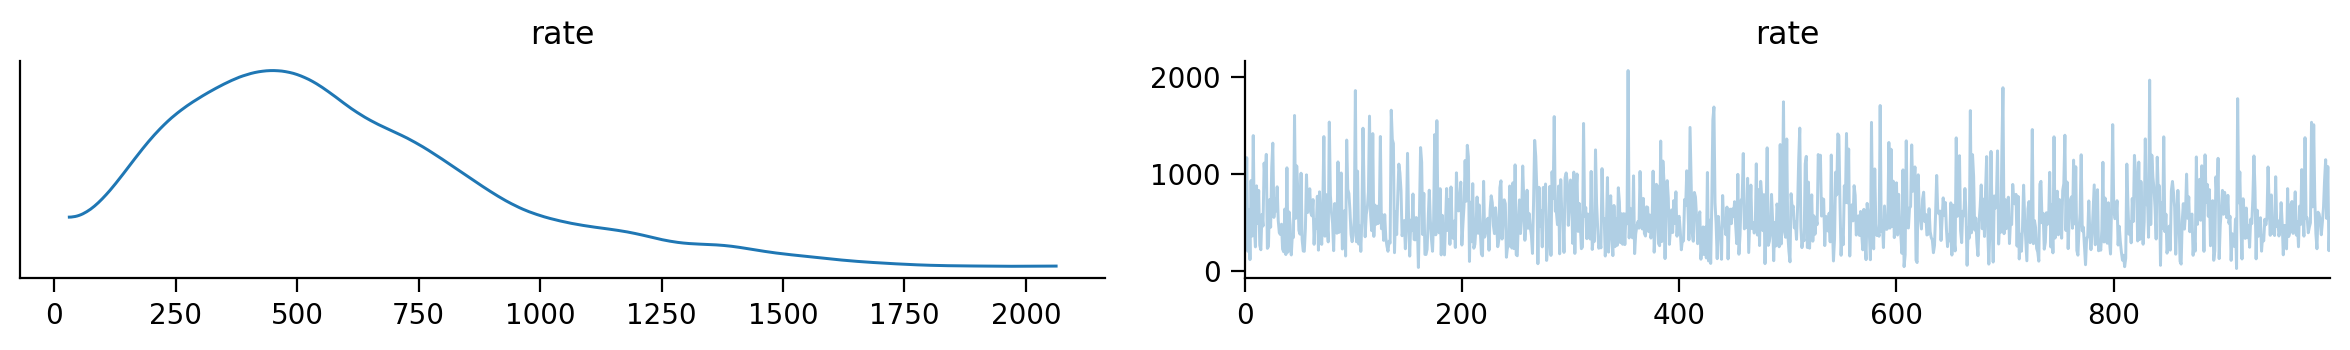

In [12]:
prior = idata_prior.prior
az.plot_trace(prior);

La distribuzione predittiva a priori suggerisce che la distribuzione a priori per il parametro `rate` è adeguata per i dati a disposizione. Eseguiamo dunque il campionamento.

In [13]:
with poisson_model:
    # Inference using MCMC
    idata = pm.sample(3000, tune=1000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rate]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 25 seconds.


Consideriamo le diagnostiche.

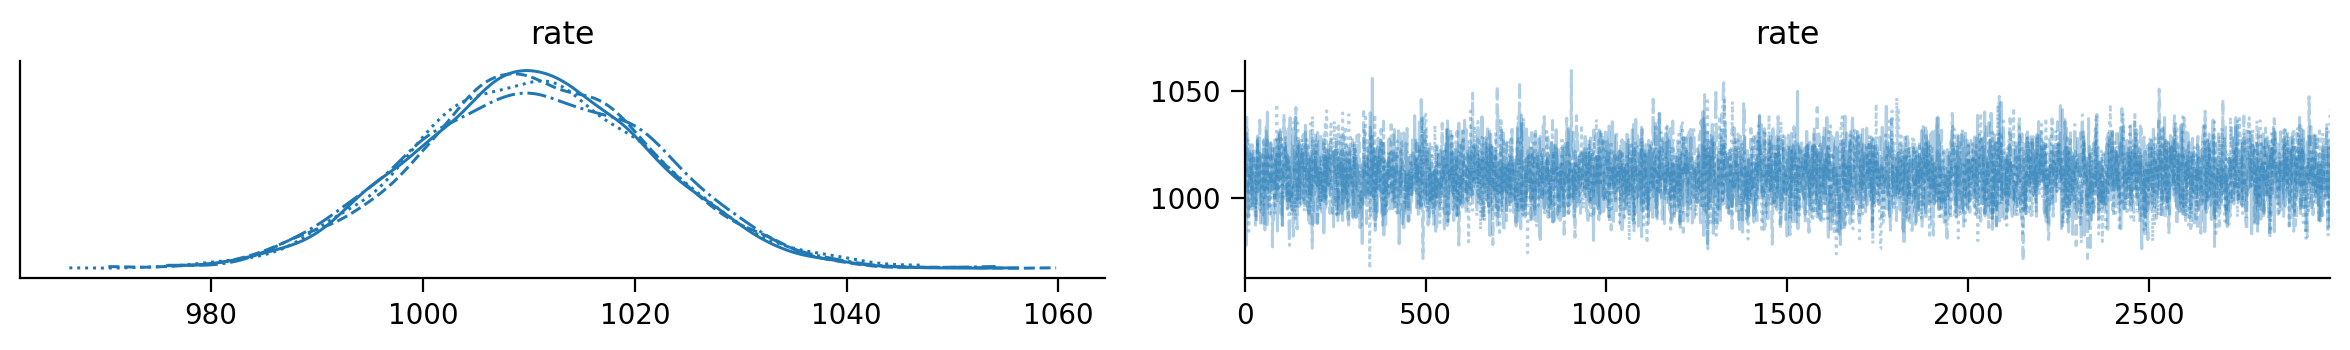

In [14]:
az.plot_trace(idata);

Il modello converge rapidamente e i grafici delle tracce sembrano ben mescolati. Esminiamo i risultati ottenuti.

In [15]:
pm.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rate,1010.49,11.315,989.105,1031.428,0.174,0.123,4213.0,5870.0,1.0


Esaminiamo la distribuzione a posteriori del parametro `rate`.

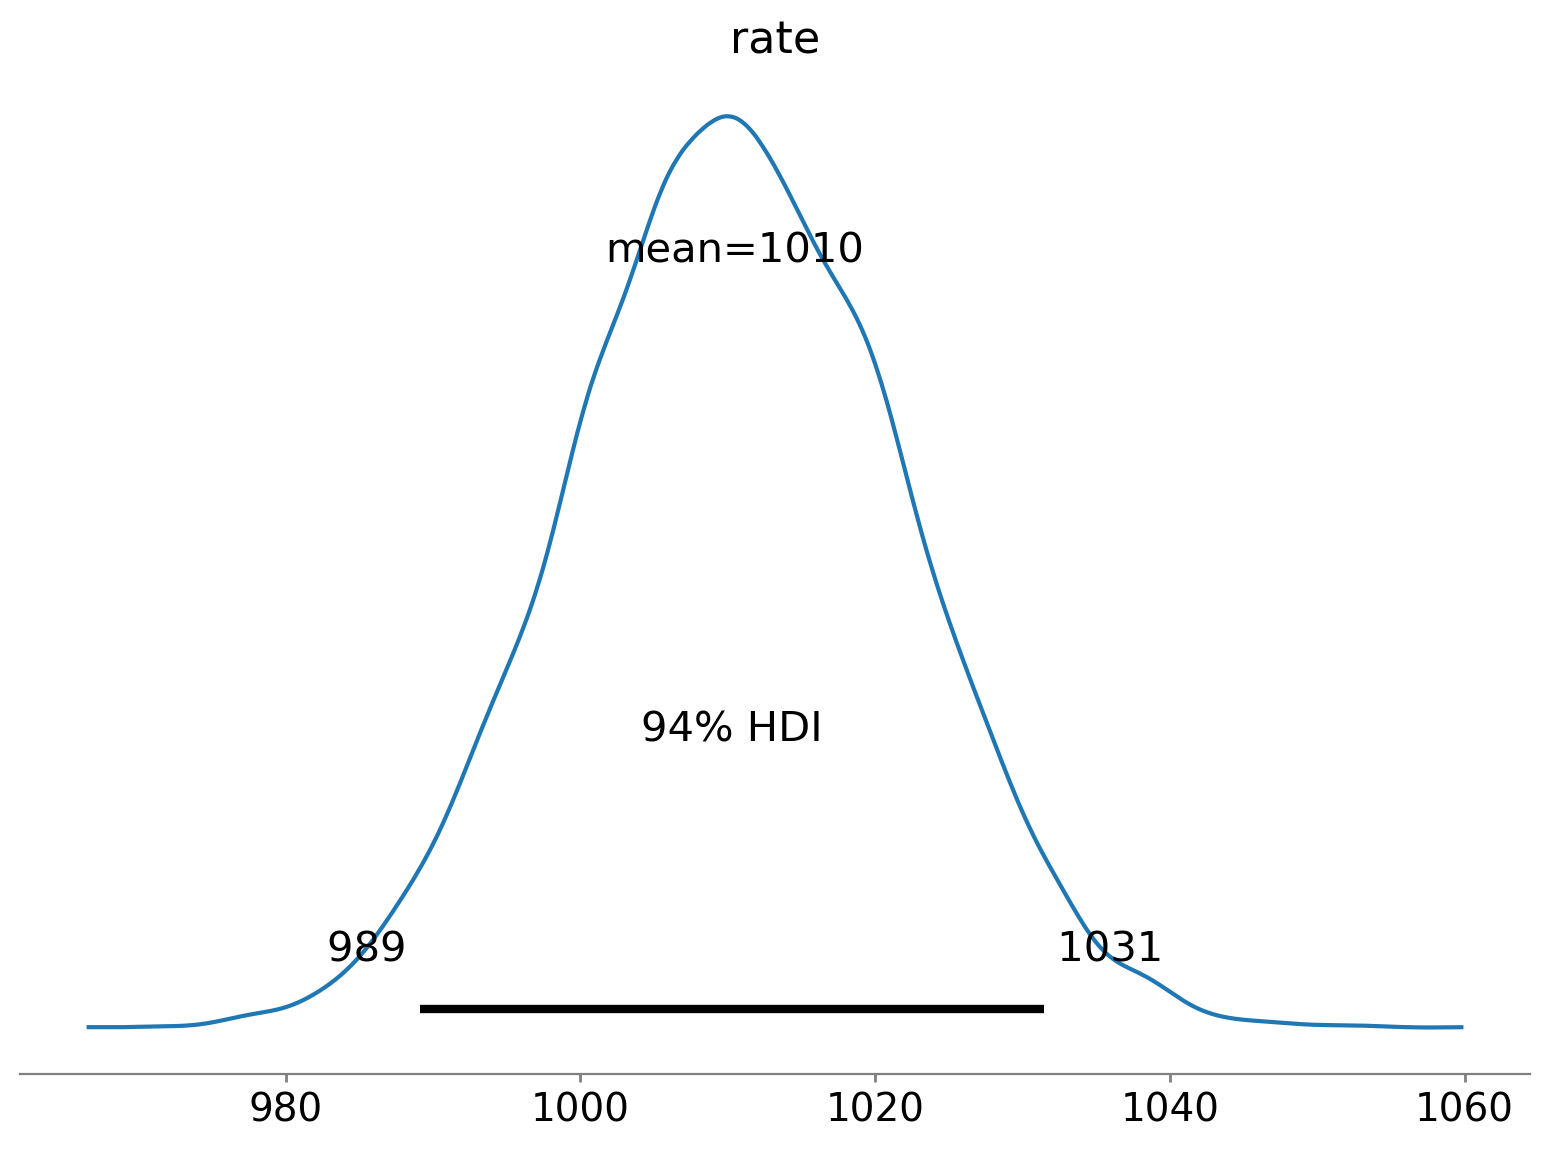

In [16]:
az.plot_posterior(idata, var_names="rate");

Eseguiamo il posterior predictive check.

In [17]:
with poisson_model:
    pm.sample_posterior_predictive(
        idata, extend_inferencedata=True, random_seed=42)

Sampling: [events]


Possiamo utilizzare `az.plot_ppc()` per verificare che i campioni predittivi a posteriori siano simili ai dati osservati.

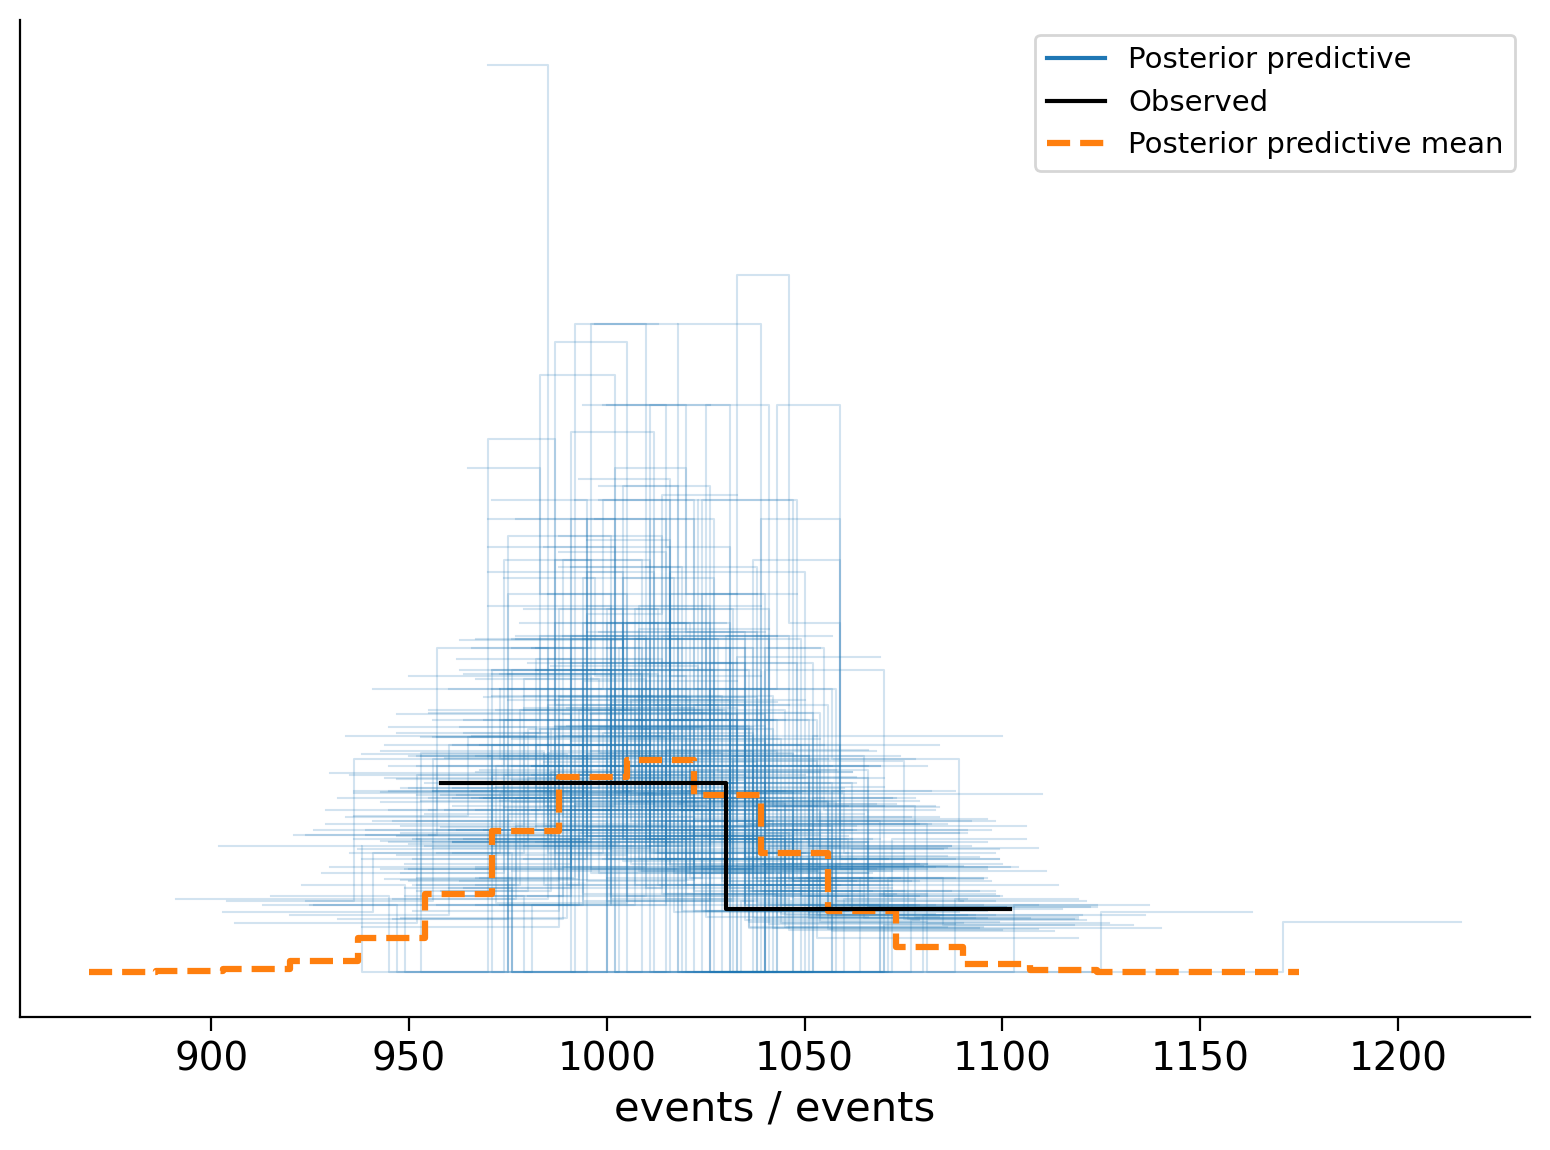

In [22]:
az.plot_ppc(idata, num_pp_samples=300);

In conclusione, possiamo affermare che il tasso stimato di sparatorie fatali da parte della polizia negli Stati Uniti è di 1011 casi all'anno, con un intervallo di credibilità del 94% di [988.53, 1031.41].

## Derivazione analitica

In realtà, il problema precedente poteva essere risolto in maniera analitica, senza ricorrere al campionamento MCMC. Infatti, la distribuzione coniugata al modello di Poisson è una densità di tipo gamma e dunque la distribuzione a posteriori è ancora una distribuzione gamma.

Consideriamo un modello di Poisson con verosimiglianza:

$$
P(Y|\theta) = \frac{e^{-\theta} \cdot \theta^Y}{Y!},
$$

dove $Y$ è il numero di eventi osservati e $\theta$ è il parametro che rappresenta il tasso di incidenza degli eventi. Supponiamo di avere una distribuzione a priori gamma con i parametri $a$ e $b$:

$$
P(\theta) = \frac{b^a}{\Gamma(a)} \cdot \theta^{a-1} \cdot e^{-b \theta},
$$

dove $a$ e $b$ sono i parametri della distribuzione gamma. Per trovare la distribuzione a posteriori, dobbiamo moltiplicare la verosimiglianza e la distribuzione a priori, e normalizzare il risultato in modo che la distribuzione risultante sia una distribuzione di probabilità valida. La distribuzione a posteriori è quindi data da:

$$
P(\theta|Y) \propto P(Y|\theta) \cdot P(\theta) = \frac{e^{-\theta} \cdot \theta^Y}{Y!} \cdot \frac{b^a}{\Gamma(a)} \cdot \theta^{a-1} \cdot e^{-b \theta}
$$

Per ottenere la distribuzione a posteriori normalizzata, dobbiamo dividere il risultato ottenuto per l'integrale di questa espressione su tutto l'intervallo dei valori di $\theta$. Semplificando e normalizzando questa espressione, otteniamo la distribuzione a posteriori per $\theta$ uguale ad una distribuzione gamma con parametri aggiornati, ovvero:

$$
P(\theta|Y) = \frac{b'^{a'}}{\Gamma(a')} \cdot \theta^{a'-1} \cdot e^{-b' \theta},
$$

dove i parametri aggiornati sono dati da

$$
a' = a + Y \\
b' = b + 1
$$

In conclusione, la distribuzione a posteriori per $\theta$, data una verosimiglianza di Poisson e una distribuzione a priori gamma, è ancora una distribuzione gamma con parametri aggiornati. 

Risolviamo dunque il problema precedente utilizzando la formula della distribuzione a posteriori riportata sopra. Se la distribuzione a priori è una distribuzione gamma di parametri α e β, la distribuzione a posteriori è ancora una gamma con parametri aggiornati. Possiamo calcolare i parametri della distribuzione a posteriori nel modo seguente:

- Parametro di forma a posteriori (α_post) = α_prior + Σ(y_i), dove Σ(y_i) rappresenta la somma dei dati osservati.
- Parametro di tasso a posteriori (β_post) = β_prior + n, dove n è il numero di punti dati.

Con questi parametri aggiornati, possiamo poi calcolare la media a posteriori della distribuzione gamma e l'intervallo di credibilità.

In [19]:
data = [1096, 1048, 1019, 997, 995, 992, 983, 958]

# Prior hyperparameters
alpha_prior = 3
beta_prior = 1 / 200

# Data summary
n = len(data)
sum_y = np.sum(data)

# Posterior hyperparameters
alpha_post = alpha_prior + sum_y
beta_post = beta_prior + n

# Posterior distribution (Gamma)
posterior_gamma = stats.gamma(alpha_post, scale=1 / beta_post)

# Calculate the mean and credibility interval (94%)
posterior_mean = posterior_gamma.mean()
credible_interval = posterior_gamma.interval(0.94)

print("Estimated Rate (Posterior Mean):", posterior_mean)
print("Credibility Interval (94%):", credible_interval)

Estimated Rate (Posterior Mean): 1010.7432854465958
Credibility Interval (94%): (989.7152329772036, 1031.9826527942685)


L'output delle istruzioni precedenti fornisce il tasso stimato a posteriori e l'intervallo di credibilità al 94%. A causa di approssimazioni numeriche, i valori non coincidono esattamente con i risultati ottenuti con PyMC, ma sono molto simili.

Un altro esempio di applicazione del modello di Poisson è presentato in appendice.

## Watermark

In [20]:
%watermark -n -u -v -iv -w

Last updated: Thu Aug 17 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pandas    : 2.0.3
matplotlib: 3.7.2
arviz     : 0.16.1
scipy     : 1.11.1
pymc      : 5.7.2
numpy     : 1.25.2

Watermark: 2.4.3

